# Wagner model

Angel Villalba-Rodríguez - A00828035@itesm.mx <br>
Constanza Álvarez-López - A00829469@itesm.mx <br>
Osamu Katagiri-Tanaka - A01212611@itesm.mx <br>
Juan Jesús Rocha-Cuervo - A01752555@itesm.mx

---

In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np;
import pandas as pd;
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)     
plt.rc('ytick', labelsize=18)
import statistics as stat

from scipy import special, optimize

---
---
# Instructions
Using the experiemntal data, fit the Wagner model to find the transient shear viscosity at different shear rates (1, 10, and 100 $1/s$). Also, using the Wagner fitting parameters, obtain the stady state first normal stress difference curve.

# Available Data
<ul>
    <li>Starting values for $\lambda_i$, $a_i$, $f_1$, $f_2$, $n_1$, and $n_2$</li>
    <li>30 shear rate vs shear viscosity experimental measurements</li>
    <li>A cross model fitting data to the experiental measurements</li>
    <li>A shear viscosity vs. time data (a.k.a. transient shear viscosity) at one shear rate (0.01 $1/s$)</li>
</ul>

# Assumptions
The fitting will be done with 8 Maxwell elements, assuming that those are enough to achive a good model fit.

# Algorithm
<ol>
    <li>Define the shear viscosity function, given by the Wagner model</li>
    <li>Define the steady state shear viscosity function at $t = \infty$</li>
    <li>Compute the fitting curve with the Wagner model</li>
    <li>Plot the Wagner fit and get the fitting parameters</li>
    <li>Obtain the transient shear viscosity at 1, 10, and 100 $1/s$ shear rates</li>
    <li>Define the steady state first normal stress difference function</li>
    <li>Obtain the steady state 1st normal stress difference plot</li>
</ol>

---
---
# Solution

## Fit viscosity measurements
### Read CSV data

In [2]:
filename = "./experimentdata.csv";
df_data = pd.read_csv(filename, sep=',');
display(df_data.head())

,Shear rate 1/s,Viscosity Pa.s
0,0.031416,3376.02
1,0.062832,3296.92
2,0.125664,3150.91
3,0.251328,3010.33
4,0.376992,2853.87


---
## Compute fitting curve with the Wagner model
### Shear viscosity as a function of a given shear rate $\dot{\gamma}_o$
### $$ \eta (t, \dot{\gamma}_o) = f_1 \sum_{i=1}^{n} \frac{a_i}{{\alpha_i}^2} \left( 1 - e^{1 - \alpha_i t} (1 - \dot{\gamma}_o n_1 \lambda_i \alpha_i t) \right) + f_2 \sum_{i=1}^{n} \frac{a_i}{{\beta_i}^2}  \left( 1 - e^{1 - \beta_i  t} (1 - \dot{\gamma}_o n_2 \lambda_i \beta_i  t) \right) $$
 
#### where:
#### $$ f_2 = 1 - f_1 $$
#### $$ \alpha_i = \frac{1 + n_1 \lambda_i \dot{\gamma}_o}{\lambda_i} $$
#### $$ \beta_i  = \frac{1 + n_2 \lambda_i \dot{\gamma}_o}{\lambda_i} $$
$\eta (t, \dot{\gamma}_o) =$ shear viscosity <br>
$t =$ time <br>
$\dot{\gamma}_o =$ shear rate <br>
$a_i =$ the $i^{th}$ elastic value of the Maxwell element <br>
$\lambda_i =$ the $i^{th}$ characteristic time of the Maxwell element <br>
$f_1, f_2, n_1, n_2$ are fitting parameters

In [3]:
dot_gamma_o = 1 # make it global

# Let's model with 8 Maxwell elements
def _eta_gamma(t, *p):
    a_          = p[0:8]
    lambda_     = p[8:16]
    f_1         = p[16]
    f_2         = 1 - f_1
    n_1         = p[17]
    n_2         = p[18]
    
    sum_1 = 0
    for i in range(0, 8, 1):
        alpha = _alpha(n_1, lambda_[i], dot_gamma_o)
        frac = a_[i] / alpha**2
        expo = np.exp(- alpha*t)
        prod = dot_gamma_o*n_1*lambda_[i]*alpha*t
        res_1 = frac*(1 - expo * (1 - prod))
        sum_1 = sum_1 + res_1
        
    sum_2 = 0
    for i in range(0, 8, 1):
        beta  = _beta(n_2, lambda_[i], dot_gamma_o)
        frac = a_[i] / beta**2
        expo = np.exp(- beta*t)
        prod = dot_gamma_o*n_2*lambda_[i]*beta*t
        res_2 = frac*(1 - expo * (1 - prod))
        sum_2 = sum_2 + res_2
    
    res = (f_1 * sum_1) + (f_2 * sum_2)
    
    return res/10

def _alpha(n_1, lambda_, dot_gamma_o):
    nume = 1 + n_1*lambda_*dot_gamma_o
    deno = lambda_
    res = nume / deno
    return res

def _beta(n_2, lambda_, dot_gamma_o):
    nume = 1 + n_2*lambda_*dot_gamma_o
    deno = lambda_
    res = nume / deno
    return res

---
### The Wagner model gives the shear viscosity vs. time of a single shear rate ...
#### now let's caculate the steady state shear viscocity at several shear rates at $t = \infty$
#### $$ \eta (t = \infty, \dot{\gamma}_o) = f_1 \sum_{1=1}^{n} \frac{a_i}{{\alpha_i}^2} + f_2 \sum_{1=1}^{n} \frac{a_i}{{\beta_i}^2} $$

In [4]:
def _eta_infty(dot_gamma, *p):
    a_          = p[0:8]
    lambda_     = p[8:16]
    f_1         = p[16]
    f_2         = 1 - f_1
    n_1         = p[17]
    n_2         = p[18]
    
    sum_1 = 0
    for i in range(0, 8, 1):
        alpha = _alpha(n_1, lambda_[i], dot_gamma)
        res_1 = a_[i] / alpha**2
        sum_1 = sum_1 + res_1
        
    sum_2 = 0
    for i in range(0, 8, 1):
        beta  = _beta(n_2, lambda_[i], dot_gamma)
        res_2 = a_[i] / beta**2
        sum_2 = sum_2 + res_2
    
    res = (f_1 * sum_1) + (f_2 * sum_2)
    
    return res/10

---
#### Compute the fitting curve with the Wagner model

In [5]:
def _fit_eta(t, eta):    
    # Initial guess
    ai      = [0.0000006, 0.0003, 0.28, 30, 10000, 2000000, 40000000, 200000000]
    lambdai = [3000, 600, 100, 10, 1, 0.1, 0.01, 0.001]
    f1 = [0.57]
    n1 = [2.8]
    n2 = [0.07]
    p = ai + lambdai + f1 + n1 + n2
    
    # Fit the model
    upbound    = [np.inf]*16 + [1] + [np.inf]*2
    model      = optimize.curve_fit(_eta_infty, t, eta, p, bounds=(0, upbound)); #bounds=(0, [3., 1., 0.5])
    parameters = model[0]

    # Show the fitting parameters
    print(parameters)
    
    return parameters

---
### Plot the Wagner fit and get $n_1$, $n_2$

[3.96453361e-07 1.78460749e-04 1.46700609e-01 5.07620566e+01
 1.01527929e+04 1.88475089e+06 2.67036501e+07 2.12078861e+08
 2.22611145e+03 4.01589068e+02 5.10605560e+01 1.50384175e-01
 1.00911954e+00 9.64964058e-02 1.31382820e-02 3.05545551e-03
 6.69494901e-01 1.71085954e+00 6.80393423e-02]


<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

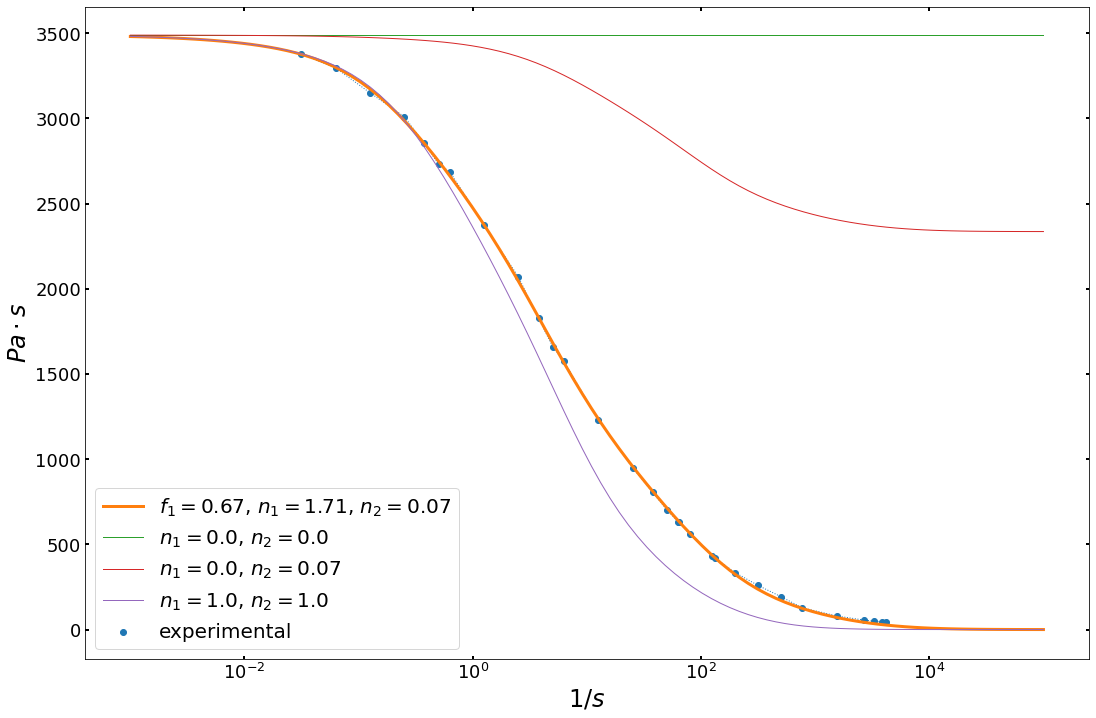

In [6]:
parameters = _fit_eta(
    pd.Series(df_data['Shear rate 1/s']).dropna(),
    pd.Series(df_data['Viscosity Pa.s']).dropna())

# Draw plot canvas
scale = 6;
plotname = 'Wagner fit';
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()
    
# plot dataset
t   = pd.Series(df_data['Shear rate 1/s']).dropna()
eta = pd.Series(df_data['Viscosity Pa.s']).dropna()
plt.scatter(t, eta, label='experimental')
plt.plot(t, eta, linewidth=1, linestyle=':')
    
# Plot fit
n_1 = parameters[17]
n_2 = parameters[18]
t = np.logspace(-3, 5, 100)
eta_fit = _eta_infty(t, *parameters)
plt.plot(t, eta_fit, linewidth=3, label = r'$f_1 = $' + str(round(parameters[16],2)) + ', ' +
         r'$n_1 = $' + str(round(n_1, 2)) + ', ' +
         r'$n_2 = $' + str(round(n_2, 2)));

# Format and Display plots
ax0.tick_params(which='both', direction='in', width=2, bottom=True, top=True, left=True, right=True);
plt.yscale('linear');
plt.xscale('log');

ax0.set(autoscale_on=False)
parameters[17] = 0
parameters[18] = 0
eta_fit = _eta_infty(t, *parameters)
plt.plot(t, eta_fit, linewidth=1, label = r'$n_1 = $' + str(round(parameters[17],2)) + ', ' +
         r'$n_2 = $' + str(round(parameters[18],2)));
parameters[17] = 0
parameters[18] = n_2
eta_fit = _eta_infty(t, *parameters)
plt.plot(t, eta_fit, linewidth=1, label = r'$n_1 = $' + str(round(parameters[17],2)) + ', ' +
         r'$n_2 = $' + str(round(parameters[18],2)));
parameters[17] = 1
parameters[18] = 1
eta_fit = _eta_infty(t, *parameters)
plt.plot(t, eta_fit, linewidth=1, label = r'$n_1 = $' + str(round(parameters[17],2)) + ', ' +
         r'$n_2 = $' + str(round(parameters[18],2)));

# restore the saved the ns
parameters[17] = n_1
parameters[18] = n_2

plt.xlabel(r'$1/s$', fontsize=24);
plt.ylabel(r'$Pa \cdot s$', fontsize=24);
#plt.title(plotname, size=24);
plt.legend(prop={'size': 20});
plt.savefig('plt_' + plotname + '.png', dpi=300, bbox_inches='tight');
display(plt);

---
### 1.a) Obtain the Transient Shear Viscosity at 1, 10 and 100 1/s

[3.96453361e-07 1.78460749e-04 1.46700609e-01 5.07620566e+01
 1.01527929e+04 1.88475089e+06 2.67036501e+07 2.12078861e+08
 2.22611145e+03 4.01589068e+02 5.10605560e+01 1.50384175e-01
 1.00911954e+00 9.64964058e-02 1.31382820e-02 3.05545551e-03
 6.69494901e-01 1.71085954e+00 6.80393423e-02]


<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

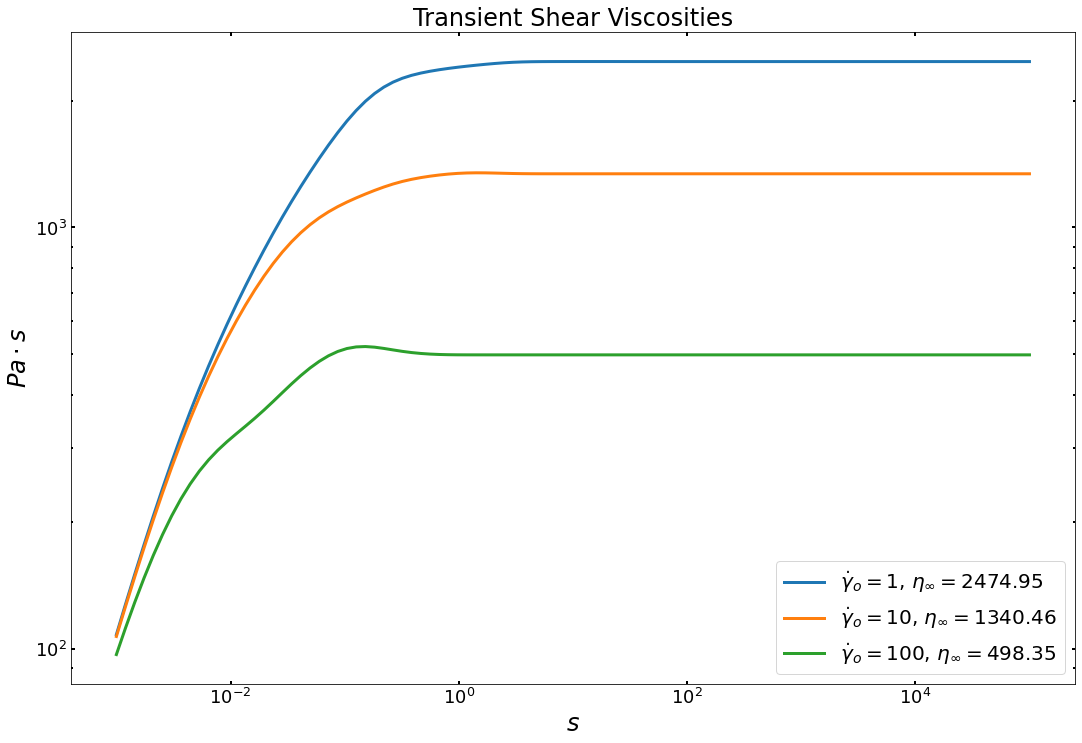

In [7]:
parameters = _fit_eta(
    pd.Series(df_data['Shear rate 1/s']).dropna(),
    pd.Series(df_data['Viscosity Pa.s']).dropna())

# Draw plot canvas
scale = 6;
plotname = 'Transient Shear Viscosities';
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()
    
# Plot fit
dot_gamma_o = 1
t = np.logspace(-3, 5, 100)
eta_fit = _eta_gamma(t, *parameters)
plt.plot(t, eta_fit, linewidth=3, label = r'$\dot{\gamma}_o = $' + str(dot_gamma_o) + ", " +
         r'$\eta_{\infty} = $' + str(round(_eta_infty(dot_gamma_o, *parameters),2)));
dot_gamma_o = 10
eta_fit = _eta_gamma(t, *parameters)
plt.plot(t, eta_fit, linewidth=3, label = r'$\dot{\gamma}_o = $' + str(dot_gamma_o) + ", " +
         r'$\eta_{\infty} = $' + str(round(_eta_infty(dot_gamma_o, *parameters),2)));
dot_gamma_o = 100
eta_fit = _eta_gamma(t, *parameters)
plt.plot(t, eta_fit, linewidth=3, label = r'$\dot{\gamma}_o = $' + str(dot_gamma_o) + ", " +
         r'$\eta_{\infty} = $' + str(round(_eta_infty(dot_gamma_o, *parameters),2)));

# Format and Display plots
ax0.tick_params(which='both', direction='in', width=2, bottom=True, top=True, left=True, right=True);
plt.yscale('log');
plt.xscale('log');
plt.xlabel(r'$s$', fontsize=24);
plt.ylabel(r'$Pa \cdot s$', fontsize=24);
plt.title(plotname, size=24);
plt.legend(prop={'size': 20});
plt.savefig('plt_' + plotname + '.png', dpi=300, bbox_inches='tight');
display(plt);

---
## Steady state first normal stress difference $N1$ at $t = \infty$
### $$ N1(t, \dot{\gamma}_o) = {\dot{\gamma}_o}^2 \left\{ f_1 \sum_{i=1}^{n} a_i {\alpha_i}^3 \left( 1 - e^{- \alpha_i t} \left[ 1 + \alpha_i t - {\alpha_i}^2 \left( n_1 \lambda_i \frac{\dot{\gamma}_o}{2} \right) t^2 \right) \right] + f_2 \sum_{i=1}^{n} a_i {\beta_i}^3 \left( 1 - e^{- \beta_i t} \left[ 1 + \beta_i t - {\beta_i}^2 \left( n_2 \lambda_i \frac{\dot{\gamma}_o}{2} \right) t^2 \right) \right] \right\} $$
### $$ N1(t=\infty, \dot{\gamma}_o) = {\dot{\gamma}_o}^2 \left\{ f_1 \sum_{i=1}^{n} a_i {\alpha_i}^3 + f_2 \sum_{i=1}^{n} a_i {\beta_i}^3 \right\} $$

In [8]:
def _N1(dot_gamma, *p):
    a_      = p[0:8]
    lambda_ = p[8:16]
    f_1     = p[16]
    f_2     = 1 - f_1
    n_1     = p[17]
    n_2     = p[18]
    
    print(p)
    
    sum_1 = 0
    for i in range(0, 8, 1):
        alpha = _alpha(n_1, lambda_[i], dot_gamma)
        res_1 = a_[i] * (alpha**3)
        sum_1 = sum_1 + res_1
        
    sum_2 = 0
    for i in range(0, 8, 1):
        beta  = _beta(n_2, lambda_[i], dot_gamma)
        res_2 = a_[i] * (beta**3)
        sum_2 = sum_2 + res_2
    
    res = dot_gamma**2 * (f_1*sum_1 + f_2*sum_2)
    
    return res/10

---
### 1.b) Obtain the steady state first normal stress dfference

(3.9645336065341767e-07, 0.00017846074924745392, 0.1467006093305382, 50.76205659755287, 10152.792916261515, 1884750.889982305, 26703650.056959767, 212078861.3393067, 2226.111452881524, 401.58906791986004, 51.060555958380846, 0.15038417496012438, 1.0091195389204213, 0.09649640578894919, 0.013138282025652327, 0.0030554555092308466, 0.6694949010007502, 1.7108595354483316, 0.0680393422606903)


<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

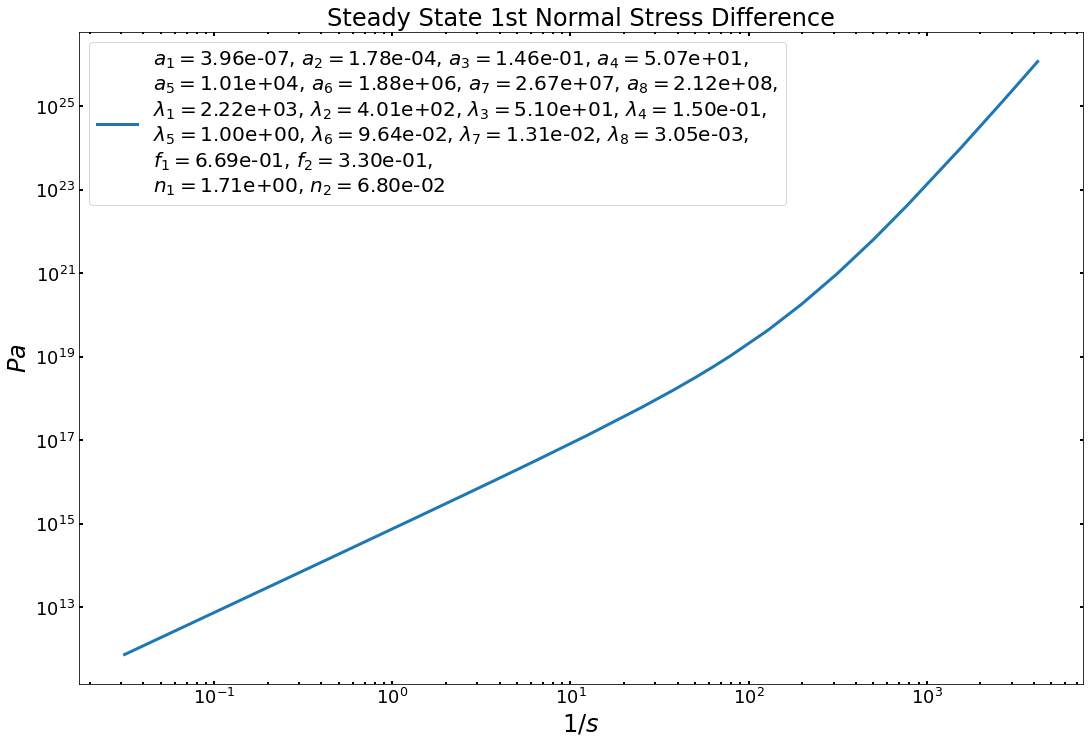

In [9]:
# Format scientific notation
def format_e(n):
    a = '%E' % n
    numeric_part    = a.split('E')[0].rstrip('0').rstrip('.')
    int_part        = numeric_part.split('.')[0]
    decimal_part    = numeric_part.split('.')[1]
    scientific_part = a.split('E')[1]
    return int_part + '.' + decimal_part[0:2] + 'e' + scientific_part

# Draw plot canvas
scale = 6;
plotname = 'Steady State 1st Normal Stress Difference';
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()

a_          = parameters[0:8]
lambda_     = parameters[8:16]
f_1         = parameters[16]
f_2         = 1 - f_1
n_1         = parameters[17]
n_2         = parameters[18]

# Plot fit
gamma = pd.Series(df_data['Shear rate 1/s']).dropna()
N1 = _N1(gamma, *parameters)
plt.plot(gamma, N1, linewidth=3, label = 
         r'$a_1 = $' + format_e(a_[0]) + ", " +
         r'$a_2 = $' + format_e(a_[1]) + ", " +
         r'$a_3 = $' + format_e(a_[2]) + ", " +
         r'$a_4 = $' + format_e(a_[3]) + ",\n" +
         r'$a_5 = $' + format_e(a_[4]) + ", " +
         r'$a_6 = $' + format_e(a_[5]) + ", " +
         r'$a_7 = $' + format_e(a_[6]) + ", " +
         r'$a_8 = $' + format_e(a_[7]) + ",\n" +
         r'$\lambda_1 = $' + format_e(lambda_[0]) + ", " +
         r'$\lambda_2 = $' + format_e(lambda_[1]) + ", " +
         r'$\lambda_3 = $' + format_e(lambda_[2]) + ", " +
         r'$\lambda_4 = $' + format_e(lambda_[3]) + ",\n" +
         r'$\lambda_5 = $' + format_e(lambda_[4]) + ", " +
         r'$\lambda_6 = $' + format_e(lambda_[5]) + ", " +
         r'$\lambda_7 = $' + format_e(lambda_[6]) + ", " +
         r'$\lambda_8 = $' + format_e(lambda_[7]) + ",\n" +
         r'$f_1 = $' + format_e(f_1) + ", " +
         r'$f_2 = $' + format_e(f_2) + ",\n" +
         r'$n_1 = $' + format_e(n_1) + ", " +
         r'$n_2 = $' + format_e(n_2));

# Format and Display plots
ax0.tick_params(which='both', direction='in', width=2, bottom=True, top=True, left=True, right=True);
plt.yscale('log');
plt.xscale('log');
plt.xlabel(r'$1/s$', fontsize=24);
plt.ylabel(r'$Pa$', fontsize=24);
plt.title(plotname, size=24);
plt.legend(prop={'size': 20});
plt.savefig('plt_' + plotname + '.png', dpi=300, bbox_inches='tight');
display(plt);

# References
<ul>
    <li>Bonilla-Rios Jaime, ESTIMATION OF THE FIRST NORMAL STRESS DIFFERENCE (N1) AND CREEP COMPLIANCE(J(t)) OF POLYPROPYLENE (PP) RESINS USING A CONSTITUTIVE EQUATION. (2020)</li>
</ul>

In [10]:
## Recover matplotlib defaults
#mpl.rcParams.update(mpl.rcParamsDefault);